# Entrenamiento y prueba de un modelo clasificador basado en redes neuronales sencillas

Si se ha realizado el notebook del árbol de decisión (cosa que se recomienda hacer antes de estudiar este), se habrá visto que el modelo obtenido no es realmente efectivo para el problema que enfrentamos. No nos permite hacer predicciones fiables sobre si es recomendable subir o no a los Lagos de Covadonga. 

Es por ello que vamos a probar con un modelo algo más complejo, dado que el anterior modelo nos salía algo subajustado debido a la escasa cantidad de datos. Aún así, como el problema es simple, tendremos que mantener un equilibrio en la complejidad. Es por ello que vamos a probar con una red neuronal no muy densa, que nos permita obtener mejores predicciones que los árboles de decisión, teniendo cuidado de que no se produzca sobreajuste.

Para el planteamiento de un modelo con redes neuronales, emplearemos la librería `scikit-learn` usada antes, pero también introduciremos la librería `keras` para hacer lo mismo de otra forma, con fines educativos.

Como nos encontramos el mismo problema que antes en la división del dataset tan pequeño en *training* y *test*, procuraremos emplear siempre que podamos técnicas de validación cruzada.

## Paquetes

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import LeaveOneOut
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.metrics import make_scorer, f1_score


## Importación de datos y tratamiento

Vamos a seguir el mismo procedimiento que en el otro notebook. Primero, descargamos los datos de los CSV's generados con las llamadas a la API de la AEMET.

In [2]:
semilla = 123
np.random.seed(semilla)
base_dir = os.path.dirname(os.path.abspath(os.getcwd()))

datos = pd.read_csv(os.path.join(base_dir, "data", "processed", "data.csv"), sep=";")
datos_sin_etiquetar = pd.read_csv(os.path.join(base_dir, "data", "processed", "data_sin_etiquetar.csv"), sep=";")

Una vez cargados, debemos convertir las variables cualitativas a *dummies* para asegurar un correcto entrenamiento y uso del modelo. Lo haremos con la función `get_dummies` de `pandas`.

Primero, extraemos las variable categóricas de los dataset:

In [3]:
categoricas = datos.select_dtypes(include= ["object", "category"]).columns
categoricas_sin_etiquetar = datos_sin_etiquetar.select_dtypes(include= ["object", "category"]).columns
categoricas

Index(['fecha', 'altonubes', 'nubosidad', 'lluvia', 'viento', 'SUBIR'], dtype='object')

No vamos a tener en cuenta las variables "fecha", dado que esta es el índice (clave primaria que identifica cada dato); ni "SUBIR", dado que es el target a predecir y no haría falta transformarlo. De hecho, la variable "fecha" podrá eliminarse por completo del dataset, dado que no influye a la hora de realizar las predicciones.

In [4]:
categoricas = categoricas.delete([0, 5])
datos.drop("fecha", axis=1, inplace=True)
categoricas

Index(['altonubes', 'nubosidad', 'lluvia', 'viento'], dtype='object')

De las "sin etiquetar", vamos a eliminar únicamente la fecha.

In [5]:
datos_sin_etiquetar.drop("fecha", axis=1, inplace=True)
categoricas_sin_etiquetar = categoricas_sin_etiquetar.delete(0)
categoricas_sin_etiquetar

Index(['altonubes', 'nubosidad', 'lluvia', 'viento'], dtype='object')

Transformamos a dummies y eliminamos las variables originales:

In [6]:
categoricas_dummies = pd.get_dummies(datos[categoricas], drop_first = True, dummy_na = True)
categoricas_sin_etiquetar_dummies = pd.get_dummies(datos_sin_etiquetar[categoricas_sin_etiquetar], drop_first = True, dummy_na = True)

datos.drop(categoricas, axis = 1, inplace = True)   # inplace para que se elimine sobre el dataset
datos_sin_etiquetar = datos_sin_etiquetar.reindex(columns=datos.drop(columns="SUBIR").columns, fill_value=0)

# Tras eliminar los atributos originales, concatenamos los nuevos atributos creados para las variables categóricas.
datos = pd.concat([datos, categoricas_dummies], axis = 1)
datos_sin_etiquetar = pd.concat([datos_sin_etiquetar, categoricas_sin_etiquetar_dummies], axis = 1)

# Mostramos cómo queda tras este proceso
datos.head()

,prec,tmin,tmax,velmedia,hrMedia,hrMax,hrMin,SUBIR,altonubes_mid,altonubes_nan,nubosidad_escasa,nubosidad_media,nubosidad_nan,lluvia_no,lluvia_posible,lluvia_nan,viento_fuerte,viento_moderado,viento_nan
0,0.0,11.9,20.4,1.4,99.0,100.0,61.0,NO,False,False,False,False,False,False,True,False,False,True,False
1,2.0,11.7,25.0,2.5,64.0,100.0,40.0,NO,False,True,False,False,True,False,False,True,False,False,True
2,23.8,13.7,26.6,5.6,54.0,94.0,34.0,SI,True,False,True,False,False,False,False,False,True,False,False
3,2.0,11.5,19.9,3.6,86.0,100.0,50.0,SI,False,True,False,False,False,False,False,False,False,True,False
4,0.0,11.4,18.2,1.4,95.0,100.0,80.0,NO,False,False,True,False,False,True,False,False,False,False,False


## Construcción del modelo

Una vez preparados los datos, vamos a proceder con el entrenamiento del modelo. Para ello, usaremos los datos etiquetados de los que disponemos, que conforman un conjunto extremadamente pequeño. Debido a esto, no conviene realizar un *train-test split* al uso, sino que optamos por una validación cruzada con *Leave-One-Out*. Esta es la mejor forma de lidiar con datasets pequeños, dado que cada instancia se usará una vez como test, y el resto como entrenamiento. Es una técnica costosa computacionalmente, pero ante la escasa cantidad de datos, no será un inconveniente.

Primero, separamos las *features* (variables predictoras del dataset) del *target* a predecir:

In [7]:
X = datos.drop(columns="SUBIR")
y = datos.SUBIR

Podemos comprobar que hay un cierto desbalance de clases en el dataset, dado que el target toma más a menudo el valor "NO". Esto puede hacer que la métrica *accuracy* pueda no ser la apropiada.

In [8]:
y.value_counts(normalize=True)

SUBIR
NO    0.625
SI    0.375
Name: proportion, dtype: float64

Procedemos ahora con la validación cruzada mediante *Leave One Out*. Además, crearemos cada modelo en cada iteración del LOO con los hiperparámetros óptimos al evaluarlo mediante un *grid* anidado dentro. 

??La medida de evaluación elegida es, finalmente, la F1-score, debido al desbalanceo de clases que existe:

In [18]:
# Grid de parámetros
rejilla_hiperparametros = [
    {'hidden_layer_sizes': [5, 10, 20, 30],   # una capa oculta -> probar con 10, 20 y 30 neuronas
    'activation': ['logistic', 'tanh', 'relu'], 
    'solver': ['lbfgs', 'adam']},
]

# Crear objeto asociado a la técnica del Leave One Out
loo = LeaveOneOut()

# Creación del modelo a utilizar
perceptron_multicapa = MLPClassifier(max_iter=2000, random_state=semilla)

# Almacenar scores en test en la validación cruzada
scores_test = []
scores_train = []

# Almacenar otras métricas en test 
precisions = []
precisions_train = []
recalls = []
recalls_train = []
accuracies = []
accuracies_train = []

# Guardar valores reales y predichos para poder representar la matriz de confusión
y_true = []
y_pred = []

# Guardar los mejores parámetros de cada iteración
best_params_list = []

# Definimos el scorer que vamos a usar
scoring = make_scorer(f1_score, pos_label="SI", zero_division=0)

# Generar tantos pares de índices como filas tenga X
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
	# Definimos el grid dentro de la iteración
    grid = GridSearchCV(
        estimator = perceptron_multicapa,
        param_grid = rejilla_hiperparametros,
        scoring = scoring,
        cv = 5,   # validación cruzada de 5 folds dentro del entrenamiento
        return_train_score = True
	)
    
	# Entrenamos el grid con los datos de train dentro de la iteración del LOO
    grid.fit(X_train, y_train)
    
	# Una vez entrenado el grid, podemos obtener el modelo que ha dado una mayor accuracy, y podemos evaluarlo en test
    best_model = grid.best_estimator_
    f1_test = grid.best_score_
    pred_test = best_model.predict(X_test)
    pred_train = best_model.predict(X_train)
    
	# Guardamos las métricas de precisión y sensibilidad
    precisions.append(precision_score(y_test, pred_test, zero_division=0, pos_label="SI"))
    precisions_train.append(precision_score(y_train, pred_train, zero_division=0, pos_label="SI"))
    recalls.append(recall_score(y_test, pred_test, zero_division=0, pos_label="SI"))
    recalls_train.append(recall_score(y_train, pred_train, zero_division=0, pos_label="SI"))
    accuracies.append(accuracy_score(y_test, pred_test))
    accuracies_train.append(accuracy_score(y_train, pred_train))
    
	# Almacenar las f1-scores y los parametros
    scores_test.append(f1_test)
    scores_train.append(f1_score(y_train, pred_train, zero_division=0, pos_label="SI"))
    best_params_list.append(grid.best_params_)
    
	# Almacenar predicciones y valores reales
    y_pred.append(pred_test[0])
    y_true.append(y_test.values[0])


# Imprimimos los resultados finales
print(f"La F1-score promedio en training con LOO es: {np.mean(scores_train):.3f}")
print(f"La F1-score promedio en test con LOO es: {np.mean(scores_test):.3f}")
print(f"La exactitud promedio en test con LOO es: {np.mean(accuracies):.3f}")
print(f"La exactitud promedio en training con LOO es: {np.mean(accuracies_train):.3f}")
print(f"La precisión promedio en test con LOO es: {np.mean(precisions):.3f}")
print(f"La precisión promedio en training con LOO es: {np.mean(precisions_train):.3f}")
print(f"La sensibilidad promedio en test con LOO es: {np.mean(recalls):.3f}")
print(f"La sensibilidad promedio en training con LOO es: {np.mean(recalls_train):.3f}")
frequent_params = max(set(tuple(p.items()) for p in best_params_list), key=best_params_list.count)
print(f"Hiperparámetros más frecuentes {frequent_params}")
best_params_final = dict(frequent_params)

/home/jorge/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jorge/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jorge/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jorge/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
 

La F1-score promedio en training con LOO es: 0.898
La F1-score promedio en test con LOO es: 0.721
La exactitud promedio en test con LOO es: 0.688
La exactitud promedio en training con LOO es: 0.917
La precisión promedio en test con LOO es: 0.250
La precisión promedio en training con LOO es: 0.884
La sensibilidad promedio en test con LOO es: 0.250
La sensibilidad promedio en training con LOO es: 0.929
Hiperparámetros más frecuentes (('activation', 'logistic'), ('hidden_layer_sizes', 20), ('solver', 'adam'))


Con este procedimiento, hemos encapsulado la búsqueda de los mejores parámetros para la creación del modelo, el entrenamiento del mismo y la evaluación de su rendimiento mediante *Leave One Out*.

En este caso, los resultados son algo más favorables que los obtenidos intentando maximizar el rendimiento del árbol de decisión, pero aún así, aunque la exactitud es bastante alta y la F1-score también; la precisión y sensibilidad son demasiado bajas. El modelo con redes neuronales funciona mejor y es más fiable que el de árboles, pero aun así puede no ser del todo confiable. Vemos también que el modelo se sobreajusta a los datos de entrenamiento y los memoriza, dado que, sobre todo en las métricas de precisión y sensibilidad, los resultados en test son alarmantemente bajos. 

El modelo final quedaría:

In [19]:
modelo_final = MLPClassifier(
	**best_params_final,
	max_iter = 2000,
	random_state = semilla
)

# Lo entrenamos ahora con todos los datos de los que disponemos
modelo_final.fit(X, y)

MLPClassifier(activation='logistic', hidden_layer_sizes=20, max_iter=2000,
              random_state=123)

Podemos completar la obtención de métricas representando la matriz de confusión, donde veremos exactamente los aciertos y fallos de este modelo:

Matriz de confusión global: 


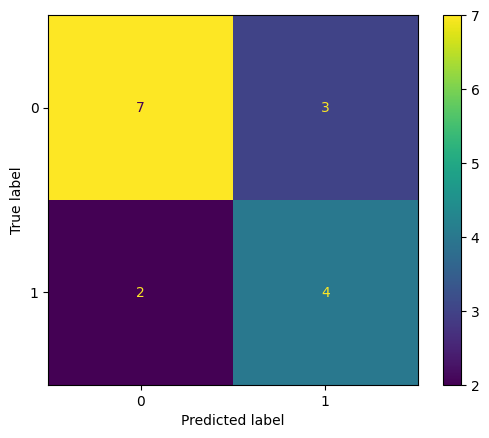

In [20]:
matriz = confusion_matrix(y_true, y_pred)
print("Matriz de confusión global: ")
disp = ConfusionMatrixDisplay(confusion_matrix=matriz)
disp.plot()

Como observamos, los resultados son algo mejores que en el modelo del árbol del decisión, y podrían considerarse incluso satisfactorios dada la escasa cantidad de datos de la que disponemos. En general hay 11 aciertos de 16, y mejora el acierto en la clase positiva, por lo que es un mucho mejor modelo para indicar si se debería subir a los lagos. 

Aun así, tiene una gran tasa de fallo (teniendo en cuenta también que los números están sesgados por la poca cantidad de datos, que hace que un fallo penalice mucho en la métrica). En conclusión, el modelo es más fiable que el árbol y podría ser tenido en cuenta para tomar una decisión, pero hay que tener en cuenta que la tasa de fallo no es despreciable.